# Laplacian algorithm for motion blur detection

In [13]:
from laplacian_blur_detection import MotionBlurDetectionLaplacian
from data_preparation import get_regions_with_labels
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from visualisations import mask_on_image, confusion_matrix, roc_pr_rec_plots
import numpy as np

In [ ]:
thresholds = range(100,2001,100)
predictions = {}
for threshold in thresholds:
    laplacian = MotionBlurDetectionLaplacian(threshold=threshold)
    prediction = laplacian.predict()
    predictions[threshold] = prediction

In [4]:
images_regions = get_regions_with_labels()

In [5]:
ground_truth_labels = [image_region.label for image_region in images_regions]

### Accuracy score for each threshold

In [13]:
accuracies = []
for threshold, prediction in predictions.items():
    predicted_labels = [pred for pred, fm in prediction]
    accuracy = accuracy_score(ground_truth_labels, predicted_labels)
    accuracies.append(accuracy)

The best accuracy is for threshold 1700.

In [6]:
best_threshold = 1700

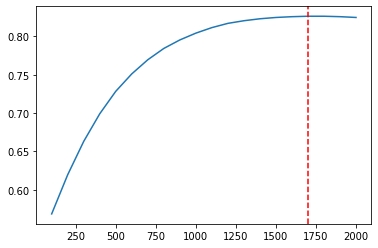

In [15]:
index_max_element = accuracies.index(max(accuracies))
plt.plot(thresholds, accuracies)
plt.axvline(x=thresholds[index_max_element], c = 'r', ls="--")
plt.show()

### Result visualisations

Sample image blur detection result for best threshold

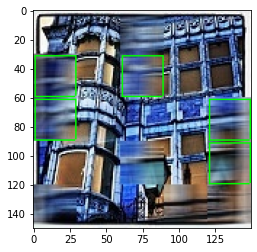

In [7]:
image_path = './results/blurred.jpg'
laplacian = MotionBlurDetectionLaplacian(threshold=1700.)
image_predictions_fm = laplacian.predict_single_image(image_path)
image_predictions = []
for i in range(4,len(image_predictions_fm)+1, 5):
    row = [pred for pred, fm in image_predictions_fm[i-4:i+1]]
    image_predictions.append(row)
image_mask = mask_on_image(image_path, image_predictions)
plt.imshow(image_mask)

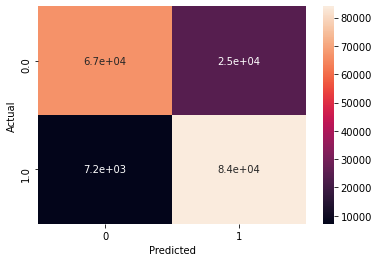

In [11]:
predicted_labels = [pred for pred, fm in predictions[best_threshold]]
confusion_matrix(ground_truth_labels, predicted_labels)

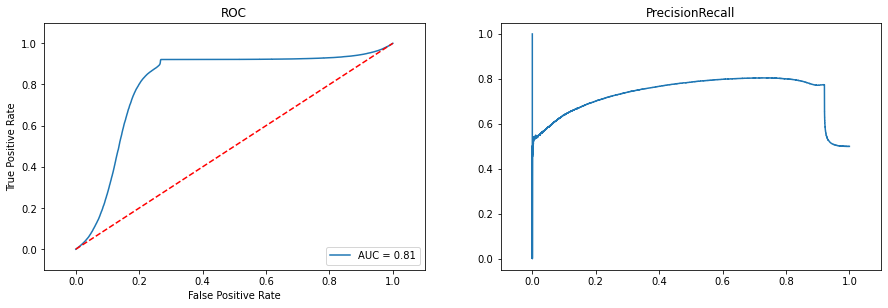

In [16]:
probabilities = []
prediction_labels = [pred for pred, fm in predictions[best_threshold]]
fm_values = [fm for pred, fm in predictions[best_threshold]]
differences = [abs(fm-best_threshold) for fm in fm_values]
max_diff = max(differences)
for i in range(len(differences)):
    predicted_class_probability = 1*differences[i]/max_diff
    if prediction_labels[i] == 0:
        probability = [1-predicted_class_probability, 
                       predicted_class_probability]
    else:
        probability = [predicted_class_probability, 
                       1-predicted_class_probability]
    probabilities.append(probability)
probabilities = np.array(probabilities)
roc_pr_rec_plots(ground_truth_labels, prediction_labels, probabilities)

In [ ]:
# predictions={}
# laplacian = MotionBlurDetectionLaplacian(threshold=1700.)
# predictions[1700] = laplacian.predict()
